In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')

sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
from munkres import munkres

sys.path.append('/home/yuncong/Brain/pipeline_scripts')
import utilities2014
reload(utilities2014)
from utilities2014 import *

import os
import time

os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/project/DavidData2014results/'
os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filter.rank import gradient

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def boundary_distance(b1, b2, sc1=None, sc2=None, loc_thresh=1500):
    '''
    Compute the distance between two boundaries.
    Each tuple consists of (edgeSet, interior_texture, exterior_textures, points, center)
    
    Parameters
    ----------
    b1 : tuple
    b2 : tuple
    sc1 : #points-by-32 array
        pre-computed shape context descriptor
    sc2 : #points-by-32 array
        pre-computed shape context descriptor
    '''
    
    _, interior_texture1, exterior_textures1, points1, center1 = b1
    _, interior_texture2, exterior_textures2, points2, center2 = b2
    if sc1 is not None:
        assert len(sc1) == points1.shape[0], 'number mismatch %d %d'%(len(sc1), points1.shape[0])
    
    if sc2 is not None:
        assert len(sc2) == points2.shape[0], 'number mismatch %d %d'%(len(sc2), points2.shape[0])

    # compute location difference
    d_loc = np.linalg.norm(center1 - center2)
    D_loc = np.maximum(0, d_loc - 500)

    if d_loc > loc_thresh:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    n1 = len(points1)
    n2 = len(points2)
    if max(n1,n2) > min(n1,n2) * 3:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    # compute interior texture difference
    D_int = chi2(interior_texture1, interior_texture2)

    # compute shape difference, exterior texture difference
    D_shape, matches = shape_context_score(points1, points2, descriptor1=sc1, descriptor2=sc2)

    bg_match = 0

    if len(matches) == 0:
        D_ext = np.inf
    else:
        ddd = []
        for i, j in matches:
            # -1 vs -1
            if np.isnan(exterior_textures1[i]).all() and np.isnan(exterior_textures2[j]).all():
                s = 0
                bg_match += 1
                ddd.append(s)
            # non -1 vs non -1
            elif not np.isnan(exterior_textures1[i]).all() and not np.isnan(exterior_textures2[j]).all():
                s = chi2(exterior_textures1[i], exterior_textures2[j])
                if OUTPUT:
                    print 'exterior', i,j,s
                ddd.append(s)
            # -1 vs non -1
            else:
                ddd.append(2.)

        if len(ddd) == 0:
            D_ext = np.inf
        elif len(ddd) == bg_match:
            D_ext = 2.
        else:
            D_ext = np.mean(ddd)
    
    D_shape = D_shape * .004

    # weighted average of four terms
    d = D_int + D_ext + D_shape + 0 * D_loc
    
    return d, D_int, D_ext, D_shape, D_loc


In [5]:
def centering(ps):
    return ps - ps.mean(axis=0)

def hausdorff(ps1, ps2, center=False):
    if center:
        ps1 = centering(ps1)
        ps2 = centering(ps2)
    D = cdist(ps1, ps2)
    return max(np.max(D.min(axis=0)), np.max(D.min(axis=1)))

def hausdorff_histograms(h1s, h2s, metric):
    Ds = cdist(h1s, h2s, metric)
    return max(np.nanmax(np.nanmin(Ds, axis=1)), np.nanmax(np.nanmin(Ds, axis=0)))


def rigid_transform_from_pairs(X,Y):
    Xcentroid = X.mean(axis=0)
    Ycentroid = Y.mean(axis=0)
    
    Xcentered = X - Xcentroid
    Ycentered = Y - Ycentroid
    
    U, S, V = np.linalg.svd(np.dot(Xcentered.T, Ycentered))
    M = [[1, 0], [0, np.linalg.det(np.dot(V, U.T))]]
    R = np.dot(V, np.dot(M, U.T))
    angle = np.arctan2(R[1,0], R[0,0])
    t = Ycentroid.T - np.dot(R, Xcentroid.T)
    
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t
   
    return T, angle

def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
    pts1_trans = pts1_trans[:,:2]/pts1_trans[:,-1][:,np.newaxis]
    return pts1_trans


# def allunique(x):
#     return len(x) == len(set(x))

def ransac_compute_rigid_transform(Dm, pts1, pts2, confidence_thresh=.01, ransac_iters=20, sample_size=5,
                                  matching_iter=10):

    high_confidence_thresh = np.sort(Dm.flat)[int(confidence_thresh * len(Dm.flat))]
#     print 'high_confidence_thresh', high_confidence_thresh
        
    high_confidence_pairs = []
    rs, cs = np.where(Dm < high_confidence_thresh)
    for r,c in zip(rs,cs):
        high_confidence_pairs.append((r, c))
    if OUTPUT:
        print 'high_confidence_pairs', high_confidence_pairs
    
#     q = time.time()
    from itertools import combinations
    possible_samples = list(combinations(high_confidence_pairs, sample_size))
    random.shuffle(possible_samples)
#     print 'comb', time.time() - q        
    
#     n_possible_samples = len([t for t in combinations(high_confidence_pairs, sample_size) 
#                         if allunique([tt[0] for tt in t]) and allunique([tt[1] for tt in t])])
#     print 'n_possible_samples', n_possible_samples
#     random.shuffle(possible_samples)
    
    
    p1s = sorted(list(set([i for i,j in high_confidence_pairs])))
    p2s = sorted(list(set([j for i,j in high_confidence_pairs])))
    n1 = len(p1s)
    n2 = len(p2s)
    
    offsets = []
    scores = []
    matches_list = []
    samples_list = []
    
    sample_counter = 0
    for ri in range(min(ransac_iters, len(possible_samples))):
        
        samples = []
        rs = set([])
        cs = set([])
        
        while True:
            s = possible_samples[sample_counter]
            sample_counter += 1
            w1, w2 = zip(*s)
            if len(set(w1)) == len(w1) and len(set(w2)) == len(w2):
                samples = s
                break

#         samples = np.array(possible_samples[ri])

        if OUTPUT:
            print '\nsamples', ri, samples
        
        X = pts1[[s[0] for s in samples]]
        Y = pts2[[s[1] for s in samples]]
                
        # generate transform hypothesis
        T, angle = rigid_transform_from_pairs(X, Y)
        if np.abs(angle) > np.pi/2:
            if OUTPUT:
                print 'angle too wide', np.rad2deg(angle)
            continue
        
        # apply transform hypothesis
        pts1_trans = rigid_transform_to(pts1, T)
        
        # iterative closest point association
        matches = None
        matches_prev = None
        
        for mi in range(matching_iter):
  
            # given transform, find matching
                    
            Dh = cdist(pts1_trans, pts2, metric='euclidean')
            Dargmin1 = Dh.argsort(axis=1)
            Dargmin0 = Dh.argsort(axis=0)
    
            D_hc_pairs = 9999 * np.ones((n1, n2))
            for i,j in high_confidence_pairs:
                if j in Dargmin1[i,:10] and i in Dargmin0[:10,j]:
                    ii = p1s.index(i)
                    jj = p2s.index(j)
                    D_hc_pairs[ii, jj] = Dh[i,j]

            if matches is not None:
                matches_prev = matches
            
#             b = time.time()
            matches_hc_pairs = np.array(zip(*np.nonzero(munkres(D_hc_pairs))))
#             print 'munkres', time.time() - b, mi
            
            q1, q2 = np.where(D_hc_pairs < 9999)
            w = zip(*[np.array(p1s)[q1], np.array(p2s)[q2]])
#                 print [(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs]
            
            matches = np.array([(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs
                                if D_hc_pairs[ii, jj] != 9999])
            # some 9999 edges will be included, the "if" above removes them

            if OUTPUT:
#                 print 'considered pairs', w
#                 print 'matches', [(i,j) for i,j in matches
                print 'matches', len(matches), '/', 'considered pairs', len(w), '/', 'all hc pairs', len(high_confidence_pairs)

            if len(matches) < 3:
                s = np.inf
                break
            else:                
                xs1 = pts1_trans[matches[:,0], 0]
                x_coverage1 = float(xs1.max() - xs1.min()) / (pts1_trans[:,0].max() - pts1_trans[:,0].min())
                ys1 = pts1_trans[matches[:,0], 1]
                y_coverage1 = float(ys1.max() - ys1.min()) / (pts1_trans[:,1].max() - pts1_trans[:,1].min())
                
                xs2 = pts2[matches[:,1], 0]
                x_coverage2 = float(xs2.max() - xs2.min())/ (pts2[:,0].max() - pts2[:,0].min())
                ys2 = pts2[matches[:,1], 1]
                y_coverage2 = float(ys2.max() - ys2.min())/ (pts2[:,1].max() - pts2[:,1].min())
                
                coverage = .5 * x_coverage1 * y_coverage1 + .5 * x_coverage2 * y_coverage2
                
                s = Dh[matches[:,0], matches[:,1]].mean() / coverage
#             s = .5 * Dm[Dh.argmin(axis=0), np.arange(len(pts2))].mean() + .5 * Dm[np.arange(len(pts1)), Dh.argmin(axis=1)].mean()            
#             s = np.mean([np.mean(Dh.min(axis=0)), np.mean(Dh.min(axis=1))])
                    
            X = pts1[matches[:,0]]
            Y = pts2[matches[:,1]]

            T, angle = rigid_transform_from_pairs(X, Y)
            if np.abs(angle) > np.pi/2:
                break

            pts1_trans = rigid_transform_to(pts1, T)

            if matches_prev is not None and all([(i,j) in matches_prev for i,j in matches]):
                break
            
                
        samples_list.append(samples)
        offsets.append(T)
        matches_list.append(matches)
        scores.append(s)
    
#         print matches
#         print s
#         plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), 
#                    center1=False, center2=False,
#                    text=True, matchings=matches)
            
    if len(scores) > 0:
        best_i = np.argmin(scores)

        best_score = scores[best_i]
        best_T = offsets[best_i]
        best_sample = samples_list[best_i]
        best_matches = matches_list[best_i]    
    
        return best_T, best_matches, best_sample, best_score
    else:
        return None, [], None, np.inf


def shape_context_score(pts1, pts2, descriptor1=None, descriptor2=None):

    if descriptor1 is None:
        descriptor1 = compute_shape_context_descriptors(pts1, dist_limit=.8)
    
    if descriptor2 is None:
        descriptor2 = compute_shape_context_descriptors(pts2, dist_limit=.8)
        
    descriptor_dists = cdist(descriptor1, descriptor2, metric='euclidean')
        
#     b = time.time()
    T, best_match, best_sample, best_score = ransac_compute_rigid_transform(descriptor_dists, pts1, pts2, 
                                                                            ransac_iters=50, confidence_thresh=0.03, 
                                                                           sample_size=3, matching_iter=10)
#     print 'ransac_compute_rigid_transform', time.time() - b

    
    if T is None and len(best_match)==0:
        return np.inf, []
    
    if OUTPUT:
        print 'best_match', best_match
        print 'best_sample', best_sample
        print 'best_score', best_score

    return best_score, best_match
    

def euclidean_dists_angles(points):
    """Returns symmetric pairwise ``dists`` and ``angles`` arrays."""
    
    n = len(points)
    dists = squareform(pdist(points, 'euclidean'))

    xd = -np.subtract.outer(points[:,0], points[:,0])
    yd = -np.subtract.outer(points[:,1], points[:,1])
    angles = np.arctan2(yd,xd)

    closest_neighbor = dists.argsort(axis=1)[:,1]
    tangent_vectors = points[closest_neighbor] - points
    tangent_angles = np.arctan2(tangent_vectors[:,1], tangent_vectors[:,0])

    angles = angles - tangent_angles[:, np.newaxis]
    angles = angles%(2*np.pi)
    angles[angles > np.pi] = angles[angles > np.pi] - 2*np.pi

    return dists, angles

def compute_r_theta_bins(n_radial_bins=5, n_polar_bins=12, dist_limit=1.):
    """
    Generate radius-theta bins for the shape context histogram.
    
    Args:
        n_radial_bins (int): number of radial bins
        n_polar_bins (int): number of polar bins
        dist_limit (float): between 0 and 1

    Returns:
        (float array, float array): (r_array, theta_array)

    """
        
    base = 10.    
    r_array = dist_limit * (np.logspace(0, 1, n_radial_bins + 1, base=10) - 1)[1:] / (base-1)
    theta_array = np.linspace(-np.pi, np.pi, n_polar_bins + 1)[1:]
    
    return r_array, theta_array

def compute_shape_context_descriptors(pts, n_radial_bins=5, n_polar_bins=12, 
                                      dist_limit=1., density=True):

    dists, angles = euclidean_dists_angles(pts)
    n_points = dists.shape[0]
    
    r_array, theta_array = compute_r_theta_bins(n_radial_bins, n_polar_bins, dist_limit)
    
    descriptors_mat = np.zeros((n_points, n_radial_bins, n_polar_bins), dtype=np.int)

    dists = dists / dists.max()

    for i in range(n_points):
        for j in range(i + 1, n_points):
            
            if dists[i, j] >= r_array[-1]:
                continue

            r_idx = np.searchsorted(r_array, dists[i, j])
            theta_idx = np.searchsorted(theta_array, angles[i, j])

            descriptors_mat[i, r_idx, theta_idx] += 1

            theta_idx = np.searchsorted(theta_array, angles[j, i])
            descriptors_mat[j, r_idx, theta_idx] += 1

    descriptors = descriptors_mat.reshape(descriptors_mat.shape[0], -1)

    if density:
        descriptors = normalize(descriptors.astype(np.float), axis=1)
    
    return descriptors

In [8]:
# lm1 = [(1, 28), (2, 30), (3, 26), (4, 3), (5, 27), (6, 1), (7, 0), (8, 2), (9, 3), (10, 29), (11, 30), (12, 0), (13, 1), (15, 28), (16, 4), (17, 26), (18, 13), (20, 14), (21, 15), (22, 31)]
# tests = [(19, 12), (19, 18)]
# correctly classified

# lm1 = [(10, 31), (12, 4), (13, 7), (14, 28), (15, 5), (16, 11), (17, 4), (18, 6), (19, 31), (20, 3), (21, 28), (22, 15), (23, 3), (24, 9), (25, 12)]
# tests = [(11, 2), (11, 16)]
# correctly classified

# lm1 = [(18, 27), (19, 23), (20, 2), (21, 30), (22, 27), (25, 24), (26, 29), (27, 23)]
# tests = [(23, 12), (23, 26)]
# # tests = [(24, 7), (24, 27)]
# # correctly classified

OUTPUT = False
import random

lm1 = [(4,0),(5,6),(7,8)]
tests = [(6, 10), (6, 7)]

scores = [[] for _ in tests]

for i, test in enumerate(tests):
    dm_test = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=test[0])
    boundary_test = dm_test.load_pipeline_result('boundaryModels', 'pkl')[test[1]]
    sc_test = dm_test.load_pipeline_result('shapeContext', 'pkl')[test[1]]

    for sec_ind, lm_ind in lm1:
        dm_atlas = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec_ind)
        boundary_atlas = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[lm_ind]
        sc_atlas = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[lm_ind]
        s = boundary_distance(boundary_test, boundary_atlas, sc_test, sc_atlas)[0]
        print sec_ind, lm_ind, s
        scores[i].append(s)

for ss in scores:
    print np.mean([s if s < np.inf else 2 for s in ss])


4 0 0.609411520397
5 6 0.455306951574
7 8 0.581597761355
4 0 0.796776108672
5 6 0.68966248755
7 8 0.373911321939
0.548772077775
0.620116639387


In [17]:
lm1 = [(1, 2), (3, 30), (4, 30), (5, 24), (6, 6), (7, 1)]
lm2 = [(6, 31), (7, 18), (10, 1), (11, 3),(3,8),(4,8),(5,7)]
# test = [(2,9)]
test = [(9,30)]

OUTPUT = False

dm_test = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=test[0][0])
boundary_test = dm_test.load_pipeline_result('boundaryModels', 'pkl')[test[0][1]]
sc_test = dm_test.load_pipeline_result('shapeContext', 'pkl')[test[0][1]]

scores1 = []
scores2 = []

for sec_ind, lm_ind in lm1:
    dm_atlas = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec_ind)
    boundary_atlas = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[lm_ind]
    sc_atlas = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[lm_ind]
    s1 = boundary_distance(boundary_test, boundary_atlas, sc_test, sc_atlas)[0]
    print sec_ind, lm_ind, s1
    scores1.append(s1)

for sec_ind, lm_ind in lm2:
    dm_atlas = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec_ind)
    boundary_atlas = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[lm_ind]
    sc_atlas = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[lm_ind]
    s2 = boundary_distance(boundary_test, boundary_atlas, sc_test, sc_atlas)[0]
    print sec_ind, lm_ind, s2
    scores2.append(s2)

    
print np.mean([s for s in scores1 if s < np.inf]), np.mean([s for s in scores2 if s < np.inf])


1 2 0.809703976858
3 30 0.838493243881
4 30 0.812008691717
5 24 0.788465238399
6 6 0.654087352287
7 1 0.844093995468
6 31 1.20525681951
7 18 1.10834520501
10 1 1.06171978902
11 3 0.869828625925
3 8 0.639713183327
4 8 0.431029668529
5 7 0.801031167621
0.791142083102 0.873846351277


In [36]:
lm1 = [(17,4), (18,6), (19,31), (20,3),  (22,15), (23,3), (24,9),(25,12)]
confusions = [(17,25), (18,0), (19,25), (20,27), (21,24), (22,28), (23,28), (24,23), (25,0), (26,27), (27,22),(28,26)]
test = [(21,28)]

OUTPUT = False

dm_test = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=test[0][0])
boundary_test = dm_test.load_pipeline_result('boundaryModels', 'pkl')[test[0][1]]
sc_test = dm_test.load_pipeline_result('shapeContext', 'pkl')[test[0][1]]

scores1 = []
scores2 = []

for sec_ind, lm_ind in lm1:
    dm_atlas = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec_ind)
    boundary_atlas = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[lm_ind]
    sc_atlas = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[lm_ind]
    s1 = boundary_distance(boundary_test, boundary_atlas, sc_test, sc_atlas)[0]
    print sec_ind, lm_ind, s1
    scores1.append(s1)
    
    for s,l in confusions:
        if s == sec_ind:
            boundary_conf = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[l]
            sc_conf = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[l]
            s2 = boundary_distance(boundary_test, boundary_conf, sc_test, sc_conf)[0]
            print s, l, s2
            scores2.append(s2)
    
print np.mean([s for s in scores1 if s < np.inf]), np.mean([s for s in scores2 if s < np.inf])

17 4 0.510018927461
17 25 1.5819545067
18 6 0.441658709666
18 0 0.626891718073
19 31 0.527647878899
19 25 1.05796731214
20 3 0.44573848298
20 27 0.894975832759
22 15 0.445054604458
22 28 0.988251419864
23 3 0.255768415305
23 28 0.716507521408
24 9 0.491183602487
24 23 1.01342533101
25 12 0.551354395081
25 0 0.837801827519
0.458553127042 0.964721933685


In [9]:
lm1 = [(1, 2), (3, 30), (4, 30), (5, 24), (6, 6), (7, 1)]
lm2 = [(6, 31), (7, 18), (10, 1), (11, 3),(3,8),(4,8),(5,7)]
test = [(2,9)]
# test = [(9,30)]

OUTPUT = False

dm_test = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=test[0][0])
boundary_test = dm_test.load_pipeline_result('boundaryModels', 'pkl')[test[0][1]]
sc_test = dm_test.load_pipeline_result('shapeContext', 'pkl')[test[0][1]]

internal_sps = dm_test.load_pipeline_result('internalSps', 'pkl')[test[0][1]]
texton_hists = dm_test.load_pipeline_result('texHist', 'npy')

X_test = []
for s in internal_sps:
    X_test.append(texton_hists[s])


scores1 = []
scores2 = []

X = []
Y = []

for sec_ind, lm_ind in lm1:
    dm_atlas = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec_ind)
    boundary_atlas = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[lm_ind]
    sc_atlas = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[lm_ind]
    s1 = boundary_distance(boundary_test, boundary_atlas, sc_test, sc_atlas)[0]
    
    internal_sps = dm_atlas.load_pipeline_result('internalSps', 'pkl')[lm_ind]
    texton_hists = dm_atlas.load_pipeline_result('texHist', 'npy')
    
    for s in internal_sps:
        X.append(texton_hists[s])
        Y.append(1)
    
    print sec_ind, lm_ind, s1
    scores1.append(s1)

for sec_ind, lm_ind in lm2:
    dm_atlas = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec_ind)
    boundary_atlas = dm_atlas.load_pipeline_result('boundaryModels', 'pkl')[lm_ind]
    sc_atlas = dm_atlas.load_pipeline_result('shapeContext', 'pkl')[lm_ind]
    s2 = boundary_distance(boundary_test, boundary_atlas, sc_test, sc_atlas)[0]
    print sec_ind, lm_ind, s2
    scores2.append(s2)

    internal_sps = dm_atlas.load_pipeline_result('internalSps', 'pkl')[lm_ind]
    texton_hists = dm_atlas.load_pipeline_result('texHist', 'npy')

    for s in internal_sps:
        X.append(texton_hists[s])
        Y.append(-1)

    
print np.mean([s for s in scores1 if s < np.inf]), np.mean([s for s in scores2 if s < np.inf])


TypeError: 'int' object has no attribute '__getitem__'

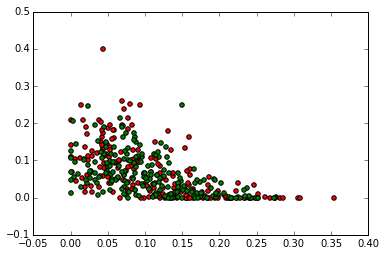

In [129]:
X = np.array(X)
Y = np.array(Y)

plt.scatter(X[:200, 2], X[:200, 5], c='r');
plt.scatter(X[-200:, 2], X[-200:, 5], c='g');

In [131]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
p = clf.predict(X_test)
print len(np.where(p == 1)[0])/float(len(X_test))
# clf.predict_proba(X_test)

0.805555555556


In [10]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("/tmp/iris.pdf") 

NameError: name 'tree' is not defined

In [130]:
from sklearn.svm import SVC, LinearSVC
# svc = SVC()
svc = SVC(kernel='poly', degree=2)
svc.fit(X, Y)

svc.predict(X)

svc.predict(X_test)

svc.decision_function(X_test)

array([[ 0.99991367],
       [ 0.99946708],
       [ 0.99929557],
       [ 0.99973314],
       [ 0.99959072],
       [ 0.99983609],
       [ 0.99982969],
       [ 0.99947951],
       [ 0.99954934],
       [ 0.99979456],
       [ 0.99963277],
       [ 0.9999782 ],
       [ 0.99959998],
       [ 0.99977883],
       [ 0.9996704 ],
       [ 0.99973908],
       [ 0.99958799],
       [ 0.99978257],
       [ 0.99956755],
       [ 1.00000955],
       [ 0.99977741],
       [ 0.99932964],
       [ 0.99987332],
       [ 0.99920895],
       [ 0.99980783],
       [ 0.9996844 ],
       [ 0.99961873],
       [ 0.99924241],
       [ 0.99974371],
       [ 0.99979786],
       [ 0.99993166],
       [ 0.99974001],
       [ 0.99977958],
       [ 0.99969047],
       [ 1.00010609],
       [ 0.99969057]])